Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.2373
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0220
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0115
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0129
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0053
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0065
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0042
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0034
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0039
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.3428
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0476
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0497
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0088
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0177
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step -

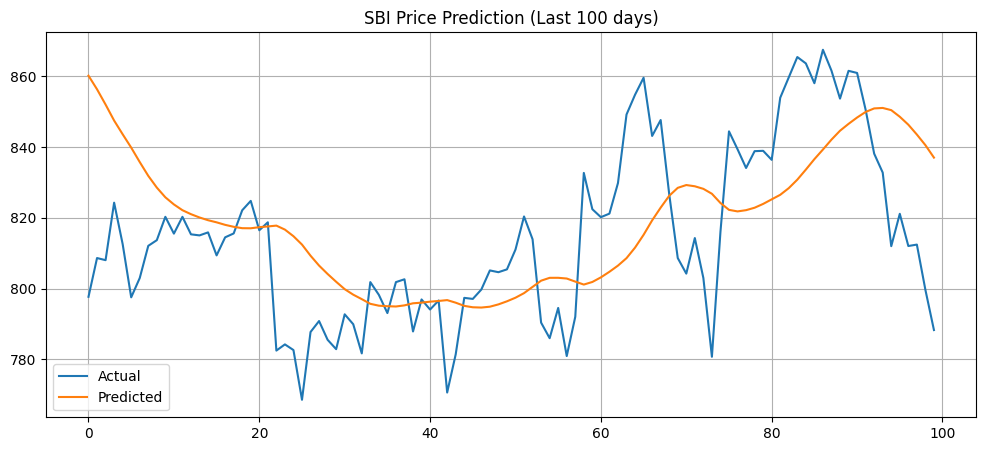

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


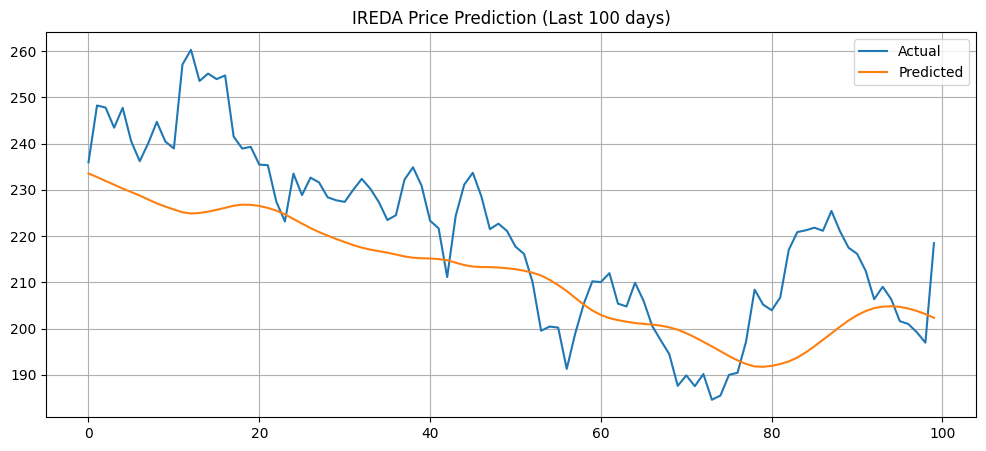

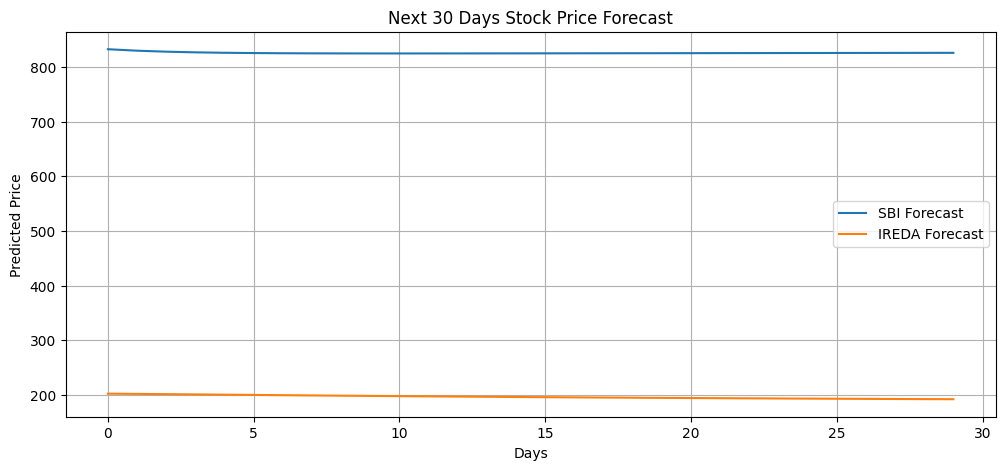

In [1]:
# Step 1: Install dependencies (Colab only)
!pip install yfinance pandas numpy matplotlib scikit-learn keras tensorflow --quiet

# Step 2: Import
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math

# Step 3: Fetch data (2023 onward for real prices)
def get_data(ticker, start_date='2023-01-01'):
    df = yf.download(ticker, start=start_date, end='2024-12-31', auto_adjust=False, progress=False)
    df = df[['Close']].dropna()
    df.to_csv(f"{ticker}_clean.csv")
    return df

sbi = get_data('SBIN.NS')
ireda = get_data('IREDA.NS', start_date='2023-11-20')

# Step 4: Preprocess for LSTM
def preprocess(df, time_step=60):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(time_step, len(scaled)):
        X.append(scaled[i-time_step:i, 0])
        y.append(scaled[i, 0])
    return np.array(X).reshape(-1, time_step, 1), np.array(y), scaler

X_sbi, y_sbi, scaler_sbi = preprocess(sbi)
X_ireda, y_ireda, scaler_ireda = preprocess(ireda)

# Step 5: Train LSTM
def train_lstm(X, y):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=64, verbose=1)
    return model

model_sbi = train_lstm(X_sbi, y_sbi)
model_ireda = train_lstm(X_ireda, y_ireda)

# Step 6: Predict & plot
def plot_prediction(model, X, y, scaler, title):
    pred = model.predict(X)
    pred = scaler.inverse_transform(pred)
    y_true = scaler.inverse_transform(y.reshape(-1, 1))
    plt.figure(figsize=(12,5))
    plt.plot(y_true[-100:], label="Actual")
    plt.plot(pred[-100:], label="Predicted")
    plt.title(f"{title} Price Prediction (Last 100 days)")
    plt.legend(); plt.grid(True)
    plt.savefig(f"{title.lower()}_prediction.png")
    plt.show()

plot_prediction(model_sbi, X_sbi, y_sbi, scaler_sbi, "SBI")
plot_prediction(model_ireda, X_ireda, y_ireda, scaler_ireda, "IREDA")

# Step 7: Forecast future prices
def forecast_next_days(model, last_data, scaler, days=30):
    temp = list(last_data[-60:])
    forecast = []
    for _ in range(days):
        x_input = scaler.transform(np.array(temp[-60:]).reshape(-1,1))
        x_input = x_input.reshape(1, 60, 1)
        pred = model.predict(x_input, verbose=0)
        price = scaler.inverse_transform(pred)[0][0]
        forecast.append(price)
        temp.append([price])
    return forecast

sbi_forecast = forecast_next_days(model_sbi, sbi['Close'].values.reshape(-1,1), scaler_sbi)
ireda_forecast = forecast_next_days(model_ireda, ireda['Close'].values.reshape(-1,1), scaler_ireda)

# Step 8: Plot forecast
plt.figure(figsize=(12,5))
plt.plot(sbi_forecast, label='SBI Forecast')
plt.plot(ireda_forecast, label='IREDA Forecast')
plt.title("Next 30 Days Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.savefig("forecast_next30days.png")
plt.show()
